<a href="https://colab.research.google.com/github/ShubhamX12/Deep-learning-/blob/main/Azymer_Diease_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#  DATASET COLLECT

In [3]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 73% 25.0M/34.1M [00:00<00:00, 65.2MB/s]
100% 34.1M/34.1M [00:00<00:00, 69.8MB/s]


In [4]:
import zipfile
zip_ref=zipfile.ZipFile("/content/alzheimers-dataset-4-class-of-images.zip","r")
zip_ref.extractall('/content')
zip_ref.close();

In [5]:
#DATA PROCESSING:
!git clone https://github.com/dvschultz/dataset-tools.git

Cloning into 'dataset-tools'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 467 (delta 124), reused 117 (delta 113), pack-reused 323
Receiving objects: 100% (467/467), 688.62 KiB | 6.50 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [6]:
!python /content/dataset-tools/dataset-tools.py --input_folder /content/AlzheimerDataset/train/VeryMildDemented/ --output_folder /content/AlzheimerDataset/train/VeryMildDemented --process_type crop --height 160 --width 120

In [7]:
IMAGE_SIZE1=160
IMAGE_SIZE2=120
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [8]:
import tensorflow  as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML


In [12]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/AlzheimerDataset/train",
    shuffle=True, 
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE, 
)

Found 5121 files belonging to 4 classes.


In [13]:
class_names=dataset.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [14]:
len(dataset)

161

In [15]:
for image_batch,label_batch in dataset.take(1):
   print(image_batch.shape)
   print(label_batch.numpy())
   pass

(32, 160, 120, 3)
[2 2 2 2 3 3 2 2 3 2 3 2 2 2 0 2 3 3 2 2 3 3 0 0 2 3 2 3 2 0 2 3]


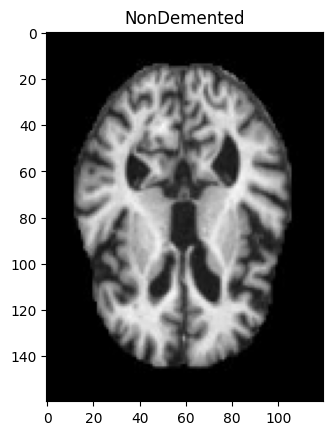

In [16]:
for image_batch,label_batch in dataset.take(1):
   plt.imshow(image_batch[0].numpy().astype("uint8"))
   plt.title(class_names[label_batch[0]]); 

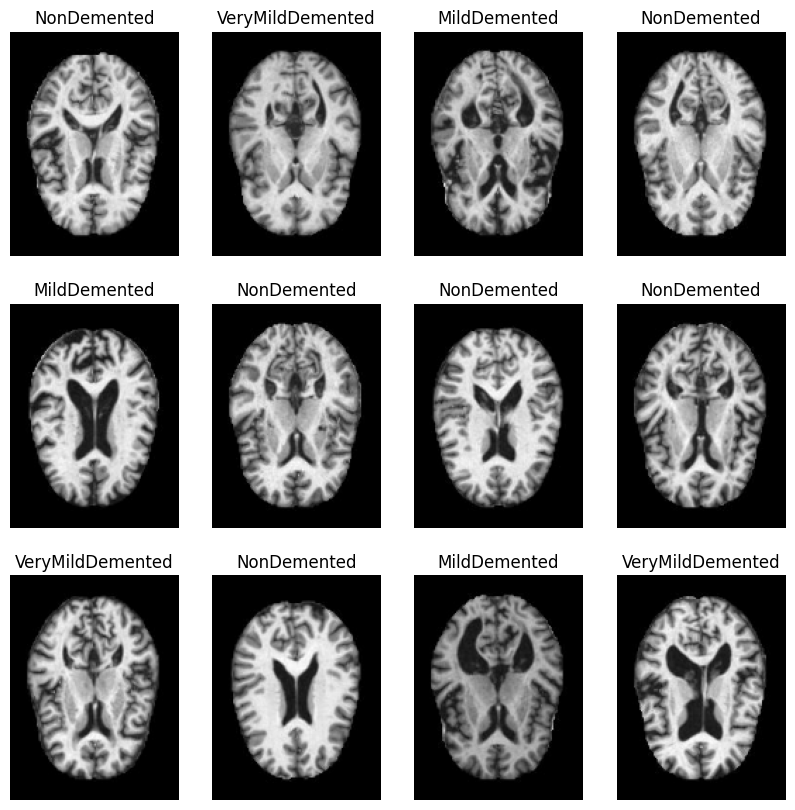

In [17]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
     ax=plt.subplot(3,4,i+1);
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]]); 
     plt.axis("Off");

TRAINIG AND VALIDATION AND TESTING:

 


70%  :-Training 
30/% :-10 valdidation 20 test

In [18]:
train_size=0.7
print(len(dataset)*train_size);

112.69999999999999


In [21]:
train_ds=dataset.take(112)
print(len(train_ds))

112


In [22]:
test_ds=dataset.skip(112)
print(len(test_ds))

49


In [23]:
val_size=0.1
print(len(dataset)*val_size)

16.1


In [24]:
val_ds=test_ds.take(20);
print(len(val_ds))

20


In [25]:
test_ds=test_ds.skip(20)
print(len(test_ds))

29


In [26]:
def get_dataset_partitions_tf(ds,train_split=0.7,val_split=0.1,test_split=0.2,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
         ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_da=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds;

In [27]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset);

In [ ]:
len(train_ds)

140

In [ ]:
len(val_ds)

20

In [ ]:
len(test_ds)

32

In [28]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE2,IMAGE_SIZE2),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [30]:
data_arugmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL GENERATE USING CNN.

In [76]:
 
input_shape=(BATCH_SIZE,IMAGE_SIZE1,IMAGE_SIZE2,3)
n_classes=4;
model=models.Sequential([
    resize_and_rescale,
    data_arugmentation,
    layers.Conv2D(128,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),  
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),    #
    layers.Dense(128,activation='relu'),# Dense neuron layers.
    layers.Dense(n_classes,activation='softmax'), #number of class neuron is added & softmax model normalize probablity of model


])
model.build(input_shape=input_shape)

In [72]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

In [77]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [78]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (32, 118, 118, 128)       3584      
                                                                 
 max_pooling2d_56 (MaxPoolin  (32, 59, 59, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (32, 57, 57, 64)          73792     
                                                                 
 max_pooling2d_57 (MaxPoolin  (32, 28, 28, 64)         0         
 g2D)                                                

In [79]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds,
)

Epoch 1/50
112/112 [==============================] - 10s 50ms/step - loss: 1.0671 - accuracy: 0.4933 - val_loss: 1.0271 - val_accuracy: 0.5469
Epoch 2/50
112/112 [==============================] - 8s 49ms/step - loss: 1.0501 - accuracy: 0.4847 - val_loss: 0.9893 - val_accuracy: 0.5176
Epoch 3/50
112/112 [==============================] - 7s 50ms/step - loss: 1.0305 - accuracy: 0.5066 - val_loss: 0.9108 - val_accuracy: 0.5586
Epoch 4/50
112/112 [==============================] - 7s 49ms/step - loss: 0.9637 - accuracy: 0.5248 - val_loss: 0.9470 - val_accuracy: 0.5820
Epoch 5/50
112/112 [==============================] - 8s 48ms/step - loss: 0.9376 - accuracy: 0.5412 - val_loss: 0.9036 - val_accuracy: 0.5371
Epoch 6/50
112/112 [==============================] - 8s 52ms/step - loss: 0.9222 - accuracy: 0.5322 - val_loss: 0.8900 - val_accuracy: 0.5254
Epoch 7/50
112/112 [==============================] - 7s 49ms/step - loss: 0.9037 - accuracy: 0.5545 - val_loss: 0.8962 - val_accuracy: 0.574

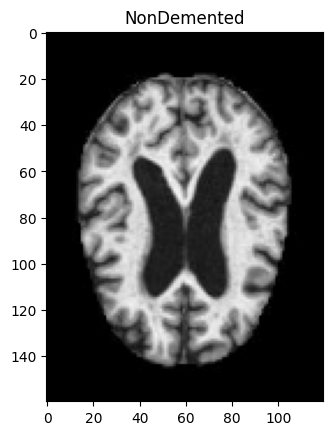

In [80]:
#TESTING MODEL
for images_batch,labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[0].numpy()])

first image to actual predict
1/1 [==============================] - 0s 91ms/step
NonDemented


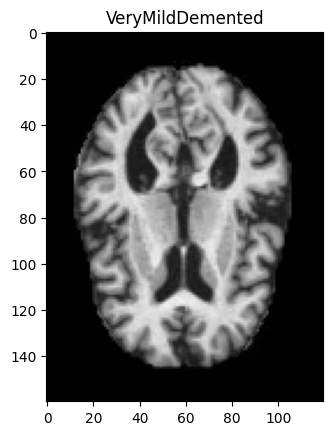

In [81]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  
    print("first image to actual predict");
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[0].numpy()]) 

    batch_predication=model.predict(images_batch)
    print(class_names[np.argmax(batch_predication[0])])

In [82]:
# MODEL PREDICT ACURACY
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


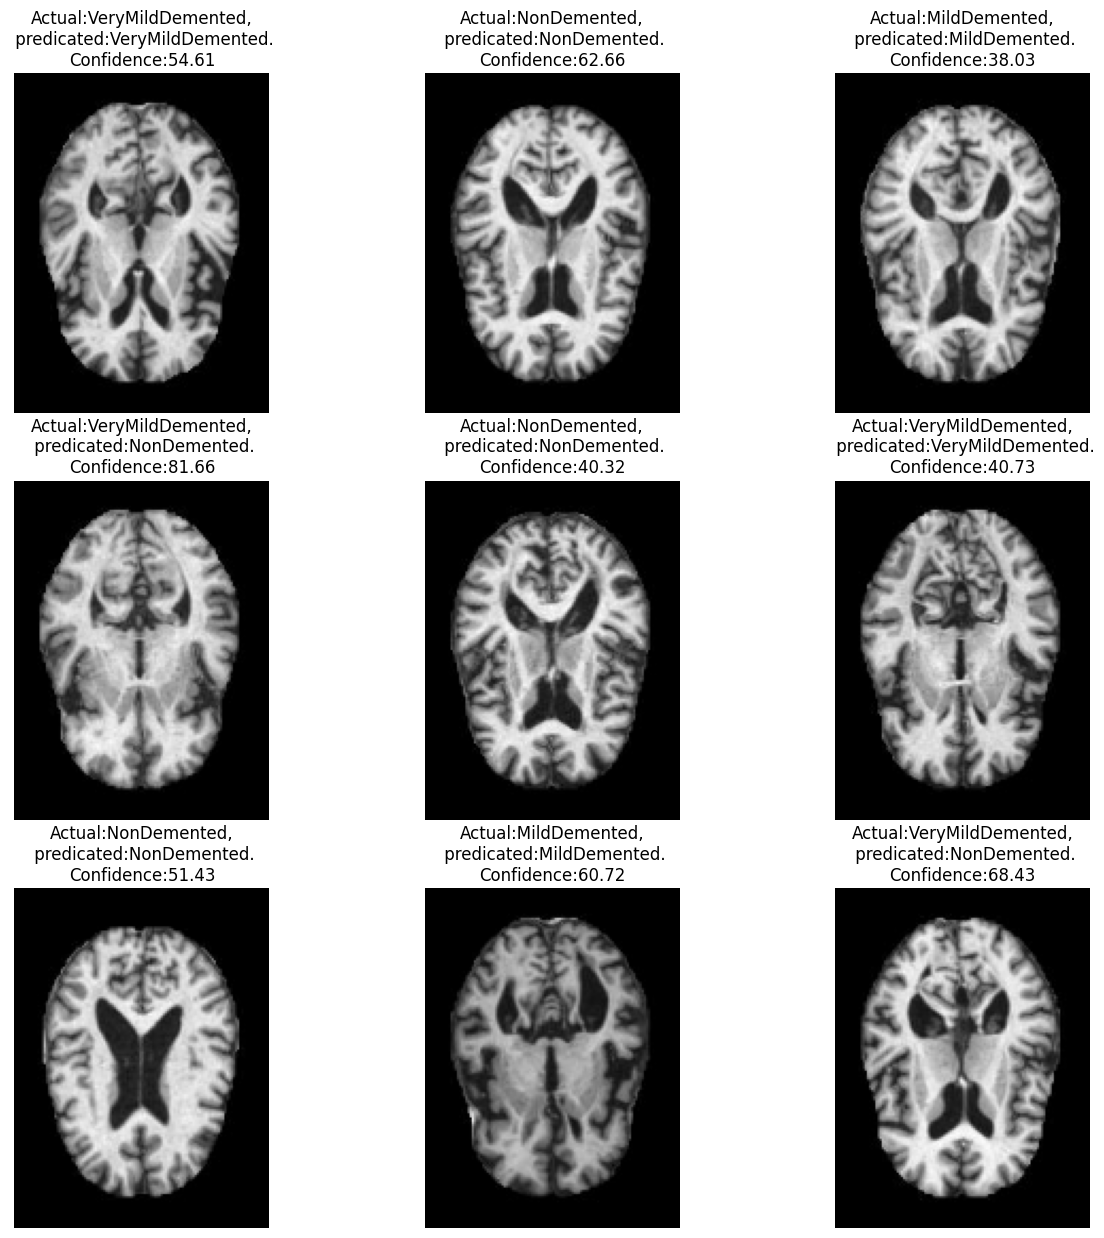

In [83]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
       ax=plt.subplot(3,3,i+1)
       plt.imshow(images[i].numpy().astype("uint8"))
       predicted_class, confidence=predict(model,images[i].numpy())
       actual_class=class_names[labels[i]]
       plt.title(f"Actual:{actual_class},\n predicated:{predicted_class}.\nConfidence:{confidence}")
       plt.axis("off")

In [ ]:
#Model save in google drive
from google.colab import drive

model_version=1
model.save("/content/drive/MyDrive/Azymer_dieases_detection/{model_version}")